In [4]:
import sys
import os

# Determine the project root directory
try:
    # This will work when running as a script
    script_dir = os.path.dirname(os.path.abspath(__file__))
    root_dir = os.path.dirname(script_dir)
except NameError:
    # This will work in interactive environments like Jupyter notebooks
    root_dir = os.path.abspath('')
    while not os.path.exists(os.path.join(root_dir, 'config.py')):
        root_dir = os.path.dirname(root_dir)
        if root_dir == os.path.dirname(root_dir):  # reached the system root directory
            raise FileNotFoundError("Could not find the project root directory containing config.py")

# Add the root directory to the Python path
sys.path.append(root_dir)

# Now you can import from config
from config import DB_HOST, DB_NAME, DB_USER, DB_PASSWORD

# Define paths relative to the root directory
data_dir = os.path.join(root_dir, 'data')
raw_data_dir = os.path.join(root_dir, 'data', 'raw')
output_dir = os.path.join(root_dir, 'data', 'output')
vis_dir = os.path.join(root_dir, 'visualisations')
dashboard_dir = os.path.join(root_dir, 'dashboard')

# Ensure directories exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(raw_data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(vis_dir, exist_ok=True)
os.makedirs(dashboard_dir, exist_ok=True)

# Print paths for verification
print(f"Project root: {root_dir}")
print(f"Raw data directory: {raw_data_dir}")
print(f"Output directory: {output_dir}")
print(f"Visualisations directory: {vis_dir}")
print(f"Dashboard directory: {dashboard_dir}")


import requests
import numpy as np
import zipfile
import io
import pandas as pd
from sqlalchemy import create_engine, inspect, text
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import urlparse
from urllib.parse import urljoin
from zipfile import ZipFile
import psycopg2
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.io as pio
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, next_monday, next_monday_or_tuesday, MO, GoodFriday, EasterMonday
from pandas.tseries.offsets import DateOffset
from dateutil.easter import easter
from pandas.tseries.holiday import EasterMonday, GoodFriday
from pandas.tseries.offsets import DateOffset
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import parser
from scipy.stats import linregress
import base64
from pathlib import Path

Project root: c:\Users\willi\OneDrive\Documents\NHS Digital Project\nhs-digital-project
Raw data directory: c:\Users\willi\OneDrive\Documents\NHS Digital Project\nhs-digital-project\data\raw
Output directory: c:\Users\willi\OneDrive\Documents\NHS Digital Project\nhs-digital-project\data\output
Visualisations directory: c:\Users\willi\OneDrive\Documents\NHS Digital Project\nhs-digital-project\visualisations
Dashboard directory: c:\Users\willi\OneDrive\Documents\NHS Digital Project\nhs-digital-project\dashboard


In [5]:
# Database connection parameters
connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}"
engine = create_engine(connection_string)

# Test the connection
try:
    with engine.connect() as conn:
        print("Successfully connected to the database!")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully connected to the database!


In [6]:
def validate_explore_data(df):
    #check for unique values
    unique_counts = df.nunique()
    print("unique values per column:")
    print(unique_counts)
    
    #check for duplicates
    duplicate_count = df.duplicated().sum()
    print("\nNumber of duplicated rows:")
    print(duplicate_count)
    
    #summary stats
    summary_stats = df.describe(), df.info(), df.head()
    print("\nSummary Statistics:")
    print(summary_stats)

#Function to add in a Season column for each dataset
def get_season(date):
    month = date.month
    if month in [6, 7, 8]:  # Summer: June to August 2021
        season = 'Summer'
    elif month in [9, 10, 11]:  # Autumn: September to November 2021
        season = 'Autumn'
    elif month in [12, 1, 2]:  # Winter: December 2021 to February 2022
        season = 'Winter'
    elif month in [3, 4, 5]:  # Spring: March to May 2022
        season = 'Spring'
    else:
        season = 'Unknown'
    return season

#A barplot function to call throughout the notebook
def create_barplot(df, x_col, y_col, title=""):
    # Ensure correct use of column names within the function
    plt.figure(figsize=(10, 6))
    ax = df.plot(kind='bar', x=x_col, y=y_col, legend=False)
    plt.title(title if title else f'Bar Plot of {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()
    

# Boxplot Function
def plot_boxplot(df, column, title=None):

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(title if title else f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

# Function to create a line plot along with a trend line
def create_lineplot(data, x_col, y_col, hue=None, title="", xlabel="", ylabel="", rotate_xticks=0, trend_line=False, ax=None,
                    grid=True, grid_style='--', grid_width=0.5, grid_color='gray', grid_alpha=0.1, legend_title=None, legend_loc='best', legend_bbox_to_anchor=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plotting the main line plot
    sns.lineplot(data=data, x=x_col, y=y_col, hue=hue, marker='o', ax=ax)

    # Adding trend lines if required
    if trend_line:
        if hue:
            for hue_value in data[hue].unique():
                subset_data = data[data[hue] == hue_value]
                x_values = subset_data[x_col].apply(pd.to_datetime).map(pd.Timestamp.toordinal)
                x_values_normalized = (x_values - x_values.min()) / (x_values.max() - x_values.min())
                slope, intercept, r_value, p_value, std_err = linregress(x_values_normalized, subset_data[y_col])
                y_pred = intercept + slope * x_values_normalized
                ax.plot(subset_data[x_col], y_pred, label=f'Trend Line ({hue_value}): y={slope:.4f}x+{intercept:.2f}', linestyle='--')
        else:
            x_values = data[x_col].apply(pd.to_datetime).map(pd.Timestamp.toordinal)
            x_values_normalized = (x_values - x_values.min()) / (x_values.max() - x_values.min())
            slope, intercept, r_value, p_value, std_err = linregress(x_values_normalized, data[y_col])
            y_pred = intercept + slope * x_values_normalized
            ax.plot(data[x_col], y_pred, label=f'Trend Line: y={slope:.4f}x+{intercept:.2f}', linestyle='--')
    
    # Setting plot titles and labels
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis='x', rotation=rotate_xticks, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Adding grid if required
    if grid:
        ax.grid(True, linestyle=grid_style, linewidth=grid_width, color=grid_color, alpha=grid_alpha)

    # Adding legend
    if legend_bbox_to_anchor:
        ax.legend(title=legend_title, loc=legend_loc, bbox_to_anchor=legend_bbox_to_anchor)
    else:
        ax.legend(title=legend_title, loc=legend_loc, fontsize=14)
    
    plt.tight_layout()
    if not ax:
        plt.show()
        
# Define a generic function to add trend lines
def add_trend_line(fig, data, x_col, y_col, label, color, linestyle='dash'):
    # Check if the x_col is datetime and convert to ordinal
    if pd.api.types.is_datetime64_any_dtype(data[x_col]):
        data = data.copy()
        data['x_ordinal'] = data[x_col].map(pd.Timestamp.toordinal)
        x_values = data['x_ordinal']
    else:
        x_values = data[x_col]

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_values, data[y_col])
    y_pred = intercept + slope * x_values

    # Add trend line to the figure
    fig.add_trace(go.Scatter(
        x=data[x_col],
        y=y_pred,
        mode='lines',
        line=dict(dash=linestyle, color=color, width=1),
        name=f'Trend Line ({label})',
        showlegend=True
    ))


# Holiday Calendar class to be used in the working days function
# https://gist.github.com/tobiolabode/acd0d10a9142b8f1f35b000e5108a915
class UKHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=next_monday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May Bank Holiday', month=5, day=1, offset=DateOffset(weekday=MO(1))),
        Holiday('Spring Bank Holiday', month=5, day=31, offset=DateOffset(weekday=MO(-1))),
        Holiday('Summer Bank Holiday', month=8, day=31, offset=DateOffset(weekday=MO(-1))),
        Holiday('Christmas Day', month=12, day=25, observance=next_monday),
        Holiday('Boxing Day', month=12, day=26, observance=next_monday_or_tuesday)
    ]

# Function to calculate working days excluding weekends and public holidays
def calculate_working_days(start_date, end_date):
    calendar = UKHolidayCalendar()
    holidays = calendar.holidays(start=start_date, end=end_date)
    weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
    working_days = weekdays.difference(holidays)
    return working_days.size

# Function to get working days in a month minus annual leave
def get_working_days_in_month(year, month):
    start_date = pd.Timestamp(year, month, 1)
    end_date = start_date + pd.offsets.MonthEnd()
    working_days = calculate_working_days(start_date, end_date)
    leave_days_per_month = 2.5 # using 30 annual leaves per annum
    adjusted_working_days = max(0, working_days - leave_days_per_month) 
    return adjusted_working_days

def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def convert_html_with_local_images(html_content):
    def replace_image(match):
        image_path = match.group(1)
        if image_path.startswith('c:'):
            try:
                base64_image = image_to_base64(image_path)
                return f'src="data:image/png;base64,{base64_image}"'
            except FileNotFoundError:
                print(f"Warning: Image file not found: {image_path}")
                return match.group(0)
        return match.group(0)

    # Replace background-image URLs
    pattern = r'background-image:\s*url\([\'"]?(c:[^)]+\.png)[\'"]?\)'
    html_content = re.sub(pattern, lambda m: f'background-image: url(data:image/png;base64,{image_to_base64(m.group(1))})', html_content)

    # Replace img src URLs
    pattern = r'src=[\'"]?(c:[^\'"]+\.png)[\'"]?'
    html_content = re.sub(pattern, replace_image, html_content)

    return html_content



In [7]:
# Function to test raw psycopg2 connection
def test_psycopg2_connection():
    try:
        conn = psycopg2.connect(
            host=host,
            database=database,
            user=user,
            password=password
        )
        cur = conn.cursor()
        cur.execute("SELECT current_database(), current_schema()")
        result = cur.fetchone()
        print(f"Successfully connected to database: {result[0]}, schema: {result[1]}")
        
        # List all schemas
        cur.execute("SELECT schema_name FROM information_schema.schemata")
        schemas = cur.fetchall()
        print("Available schemas:")
        for schema in schemas:
            print(f"- {schema[0]}")
        
        # List all tables in raw schema
        cur.execute("""
            SELECT table_name 
            FROM information_schema.tables 
            WHERE table_schema = 'raw'
        """)
        tables = cur.fetchall()
        print("Tables in raw schema:")
        for table in tables:
            print(f"- {table[0]}")
        
        cur.close()
        conn.close()
    except Exception as e:
        print(f"Error connecting with psycopg2: {e}")

# Function to test SQLAlchemy connection
def test_sqlalchemy_connection(engine):
    try:
        with engine.connect() as conn:
            result = conn.execute(text("SELECT current_database(), current_schema()"))
            for row in result:
                print(f"Successfully connected to database: {row[0]}, schema: {row[1]}")
            
            # List all schemas
            result = conn.execute(text("SELECT schema_name FROM information_schema.schemata"))
            print("Available schemas:")
            for row in result:
                print(f"- {row[0]}")
            
            # List all tables in raw schema
            result = conn.execute(text("""
                SELECT table_name 
                FROM information_schema.tables 
                WHERE table_schema = 'raw'
            """))
            print("Tables in raw schema:")
            tables = [row[0] for row in result]
            for table in tables:
                print(f"- {table}")
            
            return tables
    except Exception as e:
        print(f"Error connecting with SQLAlchemy: {e}")
        return []

# Run diagnostics
print("Testing connection with psycopg2:")
test_psycopg2_connection()

print("\nTesting connection with SQLAlchemy:")
table_names = test_sqlalchemy_connection(engine)

# If tables are found, try to get column information for one table
if table_names:
    print(f"\nAttempting to get column information for table: {table_names[0]}")
    inspector = inspect(engine)
    columns = inspector.get_columns(table_names[0], schema='raw')
    print(f"Columns in raw.{table_names[0]}:")
    for column in columns:
        print(f"- {column['name']} ({column['type']})")
else:
    print("\nNo tables found to retrieve column information.")

# Function to get data from a table in the raw schema
def get_data_from_raw_table(table_name, limit=5):
    query = text(f"SELECT * FROM raw.{table_name} LIMIT {limit}")
    try:
        with engine.connect() as conn:
            result = conn.execute(query)
            df = pd.DataFrame(result.fetchall(), columns=result.keys())
        print(f"\nSample data from raw.{table_name}:")
        print(df)
    except Exception as e:
        print(f"Error retrieving data from {table_name}: {e}")

# Get sample data from each table
for table in table_names:
    get_data_from_raw_table(table)

Testing connection with psycopg2:
Error connecting with psycopg2: name 'host' is not defined

Testing connection with SQLAlchemy:
Successfully connected to database: NHS_Digital, schema: None
Available schemas:
- raw
- staging
- reporting
- information_schema
- pg_catalog
- pg_toast
Tables in raw schema:
- all_regional_data
- national_categories_data
- combined_fte_df
- df_ccg_icb
- all_actual_duration_data

Attempting to get column information for table: all_regional_data
Columns in raw.all_regional_data:
- icb_name (TEXT)
- region_name (TEXT)
- appointment_month (TEXT)
- appt_status (TEXT)
- hcp_type (TEXT)
- appt_mode (TEXT)
- time_between_book_and_appt (TEXT)
- count_of_appointments (BIGINT)

Sample data from raw.all_regional_data:
                 icb_name               region_name appointment_month  \
0  NHS West Yorkshire ICB  North East and Yorkshire        2022-07-01   
1  NHS West Yorkshire ICB  North East and Yorkshire        2022-09-01   
2  NHS West Yorkshire ICB  North Ea

In [8]:
def get_data_from_sql(query):
    return pd.read_sql_query(query, engine)

# Updated queries to use the 'raw' schema
queries = {
    'all_actual_duration_data': 'SELECT * FROM raw.all_actual_duration_data',
    'all_regional_data': 'SELECT * FROM raw.all_regional_data',
    'combined_fte_df': 'SELECT * FROM raw.combined_fte_df',
    'national_categories': 'SELECT * FROM raw.national_categories_data',
}

# Retrieve data
data = {}
for name, query in queries.items():
    print(f"Retrieving data for {name}...")
    data[name] = get_data_from_sql(query)
    print(f"Shape of {name}: {data[name].shape}")
    print(data[name].head())
    print("\n" + "="*50 + "\n")

# Create the requested dataframes
ad = data['all_actual_duration_data']
ar = data['all_regional_data']
nc = data['national_categories']
fte = data['combined_fte_df']

print("Actual Duration (ad) dataframe:")
print(ad.shape)
print(ad.head())
print("\n" + "="*50 + "\n")

print("Appointments Regional (ar) dataframe:")
print(ar.shape)
print(ar.head())
print("\n" + "="*50 + "\n")

print("National Categories (nc) dataframe:")
print(nc.shape)
print(nc.head())

Retrieving data for all_actual_duration_data...
Shape of all_actual_duration_data: (594021, 4)
  appointment_date         actual_duration  count_of_appointments  \
0        01DEC2021             1-5 Minutes                   1539   
1        01DEC2021           31-60 Minutes                    364   
2        01DEC2021  Unknown / Data Quality                   1277   
3        01DEC2021           16-20 Minutes                    730   
4        01DEC2021           11-15 Minutes                   1073   

                               icb_name  
0  NHS North East and North Cumbria ICB  
1  NHS North East and North Cumbria ICB  
2  NHS North East and North Cumbria ICB  
3  NHS North East and North Cumbria ICB  
4  NHS North East and North Cumbria ICB  


Retrieving data for all_regional_data...
Shape of all_regional_data: (1268228, 8)
                 icb_name               region_name appointment_month  \
0  NHS West Yorkshire ICB  North East and Yorkshire        2023-11-01   
1  NHS W

In [9]:
# Calculate the total number of appointments from each DataFrame
total_appointments_ar = ar['count_of_appointments'].sum()
total_appointments_nc = nc['count_of_appointments'].sum()
total_appointments_ad = ad['count_of_appointments'].sum()

# Calculate the grand total
total_appointments = total_appointments_ar + total_appointments_nc + total_appointments_ad

print(f"Total number of appointments over the entire timeline: {total_appointments:,}")


Total number of appointments over the entire timeline: 3,185,948,825


In [10]:
nc['appointment_date'] = pd.to_datetime(nc['appointment_date'])

# Set the 'appointment_date' column as the index and create a new DataFrame
nc_indexed = nc.set_index('appointment_date')

# Resample and aggregate data by week
weekly_appointments = nc_indexed['count_of_appointments'].resample('W').sum()

# Verify the result
print(weekly_appointments.head())  # Print the first few rows to verify

C:\Users\willi\AppData\Local\Temp\ipykernel_18456\1711413484.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nc['appointment_date'] = pd.to_datetime(nc['appointment_date'])


appointment_date
2022-01-02       9672
2022-01-09    4992406
2022-01-16    6378111
2022-01-23    6388667
2022-01-30    6446940
Freq: W-SUN, Name: count_of_appointments, dtype: int64


In [11]:
# Filter for GP appointments
ar_gp = ar[ar['hcp_type'] == 'GP']

# Aggregate count_of_appointments by month and ICB
gp_appointments = ar_gp.groupby(['appointment_month', 'icb_name'])['count_of_appointments'].sum().reset_index()

# Display the first few rows of the aggregated data
print("Aggregated GP appointments by month and ICB:")
print(gp_appointments.head(10))

# Identify ICBs with the highest and lowest appointment counts
top_icbs = gp_appointments.groupby('icb_name')['count_of_appointments'].mean().sort_values(ascending=False).head(5)
bottom_icbs = gp_appointments.groupby('icb_name')['count_of_appointments'].mean().sort_values().head(5)

print("\nTop 5 ICBs by average appointment count:")
print(top_icbs)

print("\nBottom 5 ICBs by average appointment count:")
print(bottom_icbs)

# Time series of total GP appointments
total_appointments_over_time = gp_appointments.groupby('appointment_month')['count_of_appointments'].sum()

# Calculate the total number of GP appointments
total_gp_appointments = gp_appointments['count_of_appointments'].sum()
print(f"\nTotal number of GP appointments: {total_gp_appointments:,}")

# Calculate the average number of appointments per month per ICB
avg_appointments_per_month_icb = gp_appointments['count_of_appointments'].mean()
print(f"Average number of appointments per month per ICB: {avg_appointments_per_month_icb:,.2f}")

# Create the plotly figure for the line plot
fig1_trend1 = go.Figure()

# Add the total appointments over time as a line trace
fig1_trend1.add_trace(go.Scatter(
    x=total_appointments_over_time.index,
    y=total_appointments_over_time.values,
    mode='lines',
    name='Total Appointments'
))

# Add a trendline using ordinary least squares (OLS)
X = sm.add_constant(range(len(total_appointments_over_time)))
model = sm.OLS(total_appointments_over_time.values, X).fit()
trendline = model.predict(X)

fig1_trend1.add_trace(go.Scatter(
    x=total_appointments_over_time.index,
    y=trendline,
    mode='lines',
    name='Trendline'
))

# Update layout of the figure
# Generate tickvals and ticktext for every third month
tickvals = total_appointments_over_time.index[::3]
ticktext = [pd.to_datetime(t).strftime('%b\n%Y') for t in tickvals]

fig1_trend1.update_layout(
    title='Total GP Appointments Over Time',
    xaxis_title='Month',
    yaxis_title='Total Appointments',
    xaxis=dict(
        tickangle=45,
        tickvals=tickvals,
        ticktext=ticktext,
        tickmode='array'
    ),
    yaxis=dict(
        showline=True,
        side='left',  # Keep the primary y-axis on the left
        mirror='ticks',  # This will make sure the ticks are mirrored on both sides
        ticks='outside',  # Ensure ticks are visible
        showgrid=True,  # Show grid lines
    ),
    yaxis2=dict(
        showline=True,
        side='right',
        overlaying='y',
        tickmode='sync',  # Synchronize ticks with the left y-axis
        ticks='outside',
        showgrid=False,  # Don't show grid lines for the right axis to avoid clutter
    )
)

# Get HTML string for fig1_trend3
fig1_trend1_html = fig1_trend1.to_html(full_html=False, include_plotlyjs='cdn')
fig1_trend1.show()

Aggregated GP appointments by month and ICB:
  appointment_month                                           icb_name  \
0        2019-04-01  NHS Bath and North East Somerset Swindon and W...   
1        2019-04-01       NHS Bedfordshire Luton and Milton Keynes ICB   
2        2019-04-01                    NHS Birmingham and Solihull ICB   
3        2019-04-01                              NHS Black Country ICB   
4        2019-04-01  NHS Bristol North Somerset and South Glouceste...   
5        2019-04-01  NHS Buckinghamshire Oxfordshire and Berkshire ...   
6        2019-04-01            NHS Cambridgeshire and Peterborough ICB   
7        2019-04-01                    NHS Cheshire and Merseyside ICB   
8        2019-04-01           NHS Cornwall and The Isles of Scilly ICB   
9        2019-04-01                  NHS Coventry and Warwickshire ICB   

   count_of_appointments  
0                 207848  
1                 201141  
2                 299071  
3                 319095  
4    

In [12]:
ar_gp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495788 entries, 0 to 1268227
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   icb_name                    495788 non-null  object
 1   region_name                 495788 non-null  object
 2   appointment_month           495788 non-null  object
 3   appt_status                 495788 non-null  object
 4   hcp_type                    495788 non-null  object
 5   appt_mode                   495788 non-null  object
 6   time_between_book_and_appt  495788 non-null  object
 7   count_of_appointments       495788 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 34.0+ MB


In [13]:
# Convert the 'appointment_month' column to datetime and set it as index
ar_gp['appointment_month'] = pd.to_datetime(ar_gp['appointment_month'])
ar_gp_indexed = ar_gp.set_index('appointment_month')

# Group by month and sum appointments
monthly_appointments = ar_gp_indexed['count_of_appointments'].resample('M').sum()

# Perform seasonal decomposition on monthly data
decomposition = seasonal_decompose(monthly_appointments, model='additive', period=12)

# Get the observed, trend, seasonal, and residual components
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

# Extrapolate the trend using linear regression
def extend_trend(trend, observed):
    trend_series = trend.dropna()
    X = np.arange(len(trend_series)).reshape(-1, 1)
    y = trend_series.values
    model = LinearRegression()

    # Fit the model on the middle portion (existing trend)
    model.fit(X, y)

    # Predict for the entire range of the observed data
    X_full = np.arange(len(observed)).reshape(-1, 1)
    trend_full = model.predict(X_full)
    
    # Create a new series for the extended trend
    trend_extended = pd.Series(trend_full, index=observed.index)
    return trend_extended

# Extend the trend
trend_extended = extend_trend(trend, observed)

# Create interactive plot for decomposition with 2 rows
fig1_trend2 = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.03)

# Add Observed and Trend to the first row
fig1_trend2.add_trace(go.Scatter(x=observed.index, y=observed, mode='lines', name='Observed'), row=1, col=1)
fig1_trend2.add_trace(go.Scatter(x=trend_extended.index, y=trend_extended, mode='lines', name='Trend'), row=1, col=1)

# Add Seasonal to the second row
fig1_trend2.add_trace(go.Scatter(x=seasonal.index, y=seasonal, mode='lines', name='Seasonal'), row=2, col=1)

# Update layout to include title, subtitle, and centered subplot titles
fig1_trend2.update_layout(
    height=800,
    title={
        'text': "Total GP Appointments Over Time",
        'x': 0.06,
        'xanchor': 'left'
    },
    annotations=[
        dict(
            x=0.0,
            y=1.05,
            xref='paper',
            yref='paper',
            showarrow=False,
            text="Count of GP Appointments",
            font=dict(size=14)
        ),
        dict(
            x=0.5,
            y=0.99,
            xref='paper',
            yref='paper',
            showarrow=False,
            text="Observed and Trend",
            font=dict(size=14)
        ),
        dict(
            x=0.5,
            y=0.46,
            xref='paper',
            yref='paper',
            showarrow=False,
            text="Seasonal",
            font=dict(size=14)
        )
    ]
)

# Update y-axis titles
fig1_trend2.update_yaxes(title_text="Count", row=1, col=1)
fig1_trend2.update_yaxes(title_text="Count", row=2, col=1)

# Update x-axis title (only for the bottom subplot)
fig1_trend2.update_xaxes(title_text="Date", row=2, col=1)

fig1_trend2.show()

C:\Users\willi\AppData\Local\Temp\ipykernel_18456\839356469.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\willi\AppData\Local\Temp\ipykernel_18456\839356469.py:6: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [14]:
# Fit SARIMA model
sarima_model = SARIMAX(weekly_appointments, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
results = sarima_model.fit()
print(results.summary())

# Forecast future appointments for one year (52 weeks)
forecast = results.get_forecast(steps=52)
forecast_index = pd.date_range(start=weekly_appointments.index[-1] + pd.Timedelta(weeks=1), periods=52, freq='W')
forecast_df = pd.DataFrame({'forecast': forecast.predicted_mean}, index=forecast_index)

# Calculate KPIs for the preceding 12 months
preceding_12_months = weekly_appointments[-52:]
preceding_total_patients_year = preceding_12_months.sum()
preceding_avg_patients_month = preceding_total_patients_year / 12

# Calculate KPIs for the forecasted 12 months
forecasted_total_patients_year = forecast_df['forecast'].sum()
forecasted_avg_patients_month = forecasted_total_patients_year / 12

# Plot actual vs forecast
fig1_trend3 = go.Figure()
fig1_trend3.add_trace(go.Scatter(x=weekly_appointments.index, y=weekly_appointments, mode='lines', name='Observed'))
fig1_trend3.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df['forecast'], mode='lines', name='Forecast'))
fig1_trend3.update_layout(title='Actual vs Forecasted Appointments', xaxis_title='Date', yaxis_title='Appointments')

# Set the figure to fit the container width
fig1_trend3.update_layout(
    autosize=True,
    height=700,
)

# Get HTML string for fig1_trend3
fig1_trend3_html = fig1_trend3.to_html(full_html=False, include_plotlyjs='cdn')
fig1_trend3.show()

c:\Users\willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                     SARIMAX Results                                      
Dep. Variable:              count_of_appointments   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1086.777
Date:                            Mon, 23 Sep 2024   AIC                           2183.555
Time:                                    14:40:12   BIC                           2195.075
Sample:                                01-02-2022   HQIC                          2188.150
                                     - 06-02-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4742      0.667      0.711      0.477      -0.832       1.781
ma.L1         -0.6159      0.618   

In [15]:
ar

,icb_name,region_name,appointment_month,appt_status,hcp_type,appt_mode,time_between_book_and_appt,count_of_appointments
0,NHS West Yorkshire ICB,North East and Yorkshire,2023-11-01,Attended,GP,Home Visit,1 Day,313
1,NHS West Yorkshire ICB,North East and Yorkshire,2024-04-01,DNA,GP,Face-to-Face,1 Day,277
2,NHS West Yorkshire ICB,North East and Yorkshire,2022-06-01,Attended,GP,Home Visit,1 Day,40
3,NHS West Yorkshire ICB,North East and Yorkshire,2023-01-01,Attended,GP,Home Visit,1 Day,18
4,NHS West Yorkshire ICB,North East and Yorkshire,2023-05-01,DNA,GP,Face-to-Face,1 Day,120
...,...,...,...,...,...,...,...,...
1268223,NHS West Yorkshire ICB,North East and Yorkshire,2021-09-01,Unknown,Unknown,Unknown,Same Day,16
1268224,NHS West Yorkshire ICB,North East and Yorkshire,2022-07-01,DNA,GP,Face-to-Face,1 Day,306
1268225,NHS West Yorkshire ICB,North East and Yorkshire,2022-09-01,DNA,GP,Face-to-Face,1 Day,300
1268226,NHS West Yorkshire ICB,North East and Yorkshire,2022-11-01,DNA,GP,Telephone,1 Day,62


In [16]:
# Ensure the 'appointment_month' column is datetime in both DataFrames
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'])

# Filter ar DataFrame to include only GP appointments
ar_gp = ar[ar['hcp_type'] == 'GP']

# Check if 'report_month' exists in fte and rename it to 'appointment_month'
if 'report_month' in fte.columns:
    fte['report_month'] = pd.to_datetime(fte['report_month'])
    fte = fte.rename(columns={'report_month': 'appointment_month'})
    
# Create the 'Total FTE' column in the fte DataFrame
fte['Total FTE'] = fte['<= 0.4 fte'] + fte['> 0.4 to < 1 fte'] + fte['>= 1 fte']

# Merge the dataframes
FTE_ar_merge = pd.merge(ar_gp, fte, on=['icb_name', 'appointment_month'], how='left')

# Group by ICB and appointment month, and sum the count of appointments and FTE columns
FTE_ar_merge = FTE_ar_merge.groupby(['icb_name', 'appointment_month', 'region_name', 'fte-gp', '<= 0.4 fte', '> 0.4 to < 1 fte', '>= 1 fte', 'Total FTE']).agg({
    'count_of_appointments': 'sum'
}).reset_index()

# Calculate working days for each appointment month
FTE_ar_merge['Working Days'] = FTE_ar_merge['appointment_month'].apply(lambda x: get_working_days_in_month(x.year, x.month))

# Sort the dataframe
FTE_ar_merge = FTE_ar_merge.sort_values(['icb_name', 'appointment_month'])

# Forward fill FTE data
FTE_ar_merge['fte-gp'] = FTE_ar_merge.groupby('icb_name')['fte-gp'].ffill()

# Calculate Max Appointments and Utilisation Rate
FTE_ar_merge['Max Appointments'] = FTE_ar_merge['fte-gp'] * FTE_ar_merge['Working Days'] * 25
FTE_ar_merge['Utilisation Rate'] = FTE_ar_merge['count_of_appointments'] / FTE_ar_merge['Max Appointments']

# Add percentage columns based on total FTE
FTE_ar_merge['<= 0.4 fte %'] = FTE_ar_merge['<= 0.4 fte'] / FTE_ar_merge['Total FTE'] * 100
FTE_ar_merge['> 0.4 to < 1 fte %'] = FTE_ar_merge['> 0.4 to < 1 fte'] / FTE_ar_merge['Total FTE'] * 100
FTE_ar_merge['>= 1 fte %'] = FTE_ar_merge['>= 1 fte'] / FTE_ar_merge['Total FTE'] * 100

print(FTE_ar_merge.head())
print(FTE_ar_merge.columns)

# Identify the most recent month
most_recent_month = FTE_ar_merge['appointment_month'].max()

# Filter the DataFrame for the most recent month
most_recent_data = FTE_ar_merge[FTE_ar_merge['appointment_month'] == most_recent_month]

# Sum the 'Total FTE' for the most recent month
sum_total_fte = most_recent_data['Total FTE'].sum()

# Print the result
print(f"The sum of the number of FTEs for the most recent month ({most_recent_month.strftime('%B %Y')}) is: {sum_total_fte}")

                          icb_name appointment_month region_name  fte-gp  \
0  NHS Birmingham and Solihull ICB        2022-09-01    Midlands  925.03   
1  NHS Birmingham and Solihull ICB        2022-10-01    Midlands  925.03   
2  NHS Birmingham and Solihull ICB        2022-11-01    Midlands  925.03   
3  NHS Birmingham and Solihull ICB        2022-12-01    Midlands  925.03   
4  NHS Birmingham and Solihull ICB        2023-01-01    Midlands  925.03   

   <= 0.4 fte  > 0.4 to < 1 fte  >= 1 fte  Total FTE  count_of_appointments  \
0        87.0             579.0     242.0      908.0                 380931   
1        87.0             579.0     242.0      908.0                 386693   
2        87.0             579.0     242.0      908.0                 410126   
3        87.0             579.0     242.0      908.0                 361952   
4        87.0             579.0     242.0      908.0                 406294   

   Working Days  Max Appointments  Utilisation Rate  <= 0.4 fte %  \

In [17]:

# Group by appointment month and calculate mean percentages
fte_grouped = FTE_ar_merge.groupby('appointment_month').agg({
    '<= 0.4 fte %': 'mean',
    '> 0.4 to < 1 fte %': 'mean',
    '>= 1 fte %': 'mean'
}).reset_index()

# Function to convert and validate percentage values
def convert_percentage(value):
    if pd.isna(value):
        return np.nan
    if 0 <= value <= 1:
        return value * 100
    elif 1 < value <= 100:
        return value
    else:
        return np.nan

# Apply the conversion function to the percentage columns
for col in ['<= 0.4 fte %', '> 0.4 to < 1 fte %', '>= 1 fte %']:
    fte_grouped[col] = fte_grouped[col].apply(convert_percentage)

# Create the subplots
fig2_GP1 = make_subplots(
    rows=1, cols=3,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=("< 15 hours", "15 to 37.5 hours", "> 37.5 hours")
)

# Add the first subplot
fig2_GP1.add_trace(go.Scatter(
    x=fte_grouped['appointment_month'], y=fte_grouped['<= 0.4 fte %']/100,
    mode='lines', line=dict(width=2, color='orange'),
    fill='tozeroy',
    name='< 15 hours',
    hoverinfo='x+y'
), row=1, col=1)

# Add the second subplot
fig2_GP1.add_trace(go.Scatter(
    x=fte_grouped['appointment_month'], y=fte_grouped['> 0.4 to < 1 fte %']/100,
    mode='lines', line=dict(width=2, color='purple'),
    fill='tozeroy',
    name='15 to 37.5 hours',
    hoverinfo='x+y'
), row=1, col=2)

# Add the third subplot
fig2_GP1.add_trace(go.Scatter(
    x=fte_grouped['appointment_month'], y=fte_grouped['>= 1 fte %']/100,
    mode='lines', line=dict(width=2, color='deeppink'),
    fill='tozeroy',
    name='> 37.5 hours',
    hoverinfo='x+y'
), row=1, col=3)

# Update layout
fig2_GP1.update_layout(
    title='Distribution of GP FTE Types Over Time',
    legend=dict(title='FTE Type', orientation='h', yanchor='bottom', y=-0.2, xanchor='right', x=1),
    margin=dict(l=40, r=40, t=40, b=40),
    template='plotly_white'
)

# Update y-axes for all subplots
for i in range(1, 4):
    fig2_GP1.update_yaxes(
        tickformat='.0%',
        range=[0, 1],
        row=1, col=i
    )

# Update x-axis
fig2_GP1.update_xaxes(
    tickmode='linear',
    dtick='M6',
    tickformat='%b %y',
    tickangle=45
)

fig2_GP1_html = fig2_GP1.to_html(full_html=False, include_plotlyjs='cdn')

# Show the plot
fig2_GP1.show()

# Print the first few rows of the data to verify
print(fte_grouped.head())

  appointment_month  <= 0.4 fte %  > 0.4 to < 1 fte %  >= 1 fte %
0        2022-09-01      7.919034           68.102999   23.977967
1        2022-10-01      7.919034           68.102999   23.977967
2        2022-11-01      7.919034           68.102999   23.977967
3        2022-12-01      7.919034           68.102999   23.977967
4        2023-01-01      7.919034           68.102999   23.977967


In [18]:
# Find the trend values for September 2022 and June 2024
sept_2022 = trend_extended['2022-09-01':'2022-09-30'].mean()
june_2024 = trend_extended['2024-06-01':'2024-06-30'].mean()  # Note: Changed to June 30

# Calculate the percent increase
percent_increase = ((june_2024 - sept_2022) / sept_2022) * 100

print(f"September 2022 average: {sept_2022:.2f}")
print(f"June 2024 average: {june_2024:.2f}")
print(f"Percent increase from September 2022 to June 2024: {percent_increase:.2f}%")

# Calculate average monthly appointments
avg_monthly_appointments_2022 = trend_extended['2022-09-01':'2022-09-30'].mean()
avg_monthly_appointments_2024 = trend_extended['2024-06-01':'2024-06-30'].mean()  # Note: Changed to June 30

print(f"Average monthly appointments in September 2022: {avg_monthly_appointments_2022:.0f}")
print(f"Average monthly appointments in June 2024: {avg_monthly_appointments_2024:.0f}")

# Calculate yearly totals
yearly_total_2022 = avg_monthly_appointments_2022 * 12
yearly_total_2024 = avg_monthly_appointments_2024 * 12

print(f"Yearly total appointments (based on Sept 2022): {yearly_total_2022:.0f}")
print(f"Yearly total appointments (based on June 2024): {yearly_total_2024:.0f}")

September 2022 average: 13053459.51
June 2024 average: nan
Percent increase from September 2022 to June 2024: nan%
Average monthly appointments in September 2022: 13053460
Average monthly appointments in June 2024: nan
Yearly total appointments (based on Sept 2022): 156641514
Yearly total appointments (based on June 2024): nan


In [19]:
# Ensure 'appointment_month' is in datetime format
fte['appointment_month'] = pd.to_datetime(fte['appointment_month'], format='%Y-%m', errors='coerce')

# Group by appointment month and sum the Total FTE
fte_summed = fte.groupby('appointment_month')['Total FTE'].sum().reset_index()

# Create the figure
fig_total_fte = go.Figure()

# Add the Total FTE trace
fig_total_fte.add_trace(go.Scatter(
    x=fte_summed['appointment_month'],
    y=fte_summed['Total FTE'],
    mode='lines+markers',
    name='Total FTE',
    line=dict(color='blue', width=2),
    marker=dict(size=8)
))

# Update layout
fig_total_fte.update_layout(
    title='Total Summed FTE Over Time',
    xaxis_title='Date',
    yaxis_title='Total FTE',
    template='plotly_white',
    hovermode='x unified'
)

# Update x-axis
fig_total_fte.update_xaxes(
    tickmode='linear',
    dtick='M3',  # Show tick every 3 months
    tickformat='%b %Y',
    tickangle=45
)

# Update y-axis to show comma-separated thousands
fig_total_fte.update_yaxes(
    tickformat=',',
)

# Show the plot
fig_total_fte.show()

# Convert to HTML for your dashboard
fig_total_fte_html = fig_total_fte.to_html(full_html=False, include_plotlyjs='cdn')

# Print the first few rows of the summed data to verify
print(fte_summed.head())

# Calculate and print the most recent month's total FTE
most_recent_month = fte_summed['appointment_month'].max()
most_recent_fte = fte_summed.loc[fte_summed['appointment_month'] == most_recent_month, 'Total FTE'].values[0]
print(f"FTE for GPs for the most recent month ({most_recent_month.strftime('%B %Y')}) is: {most_recent_fte:.2f}")

  appointment_month  Total FTE
0        2022-09-01    35403.0
1        2022-10-01    35403.0
2        2022-11-01    35403.0
3        2022-12-01    35403.0
4        2023-01-01    35403.0
FTE for GPs for the most recent month (July 2024) is: 36143.00


In [20]:
fte

,appointment_month,icb_name,<= 0.4 fte,> 0.4 to < 1 fte,>= 1 fte,fte-gp,Total FTE
0,2022-09-01,"NHS Bath and North East Somerset, Swindon and ...",70.0,452.0,105.0,613.03,627.0
1,2022-10-01,"NHS Bath and North East Somerset, Swindon and ...",70.0,452.0,105.0,613.03,627.0
2,2022-11-01,"NHS Bath and North East Somerset, Swindon and ...",70.0,452.0,105.0,613.03,627.0
3,2022-12-01,"NHS Bath and North East Somerset, Swindon and ...",70.0,452.0,105.0,613.03,627.0
4,2023-01-01,"NHS Bath and North East Somerset, Swindon and ...",70.0,452.0,105.0,613.03,627.0
...,...,...,...,...,...,...,...
961,2024-03-01,NHS West Yorkshire ICB,92.0,1216.0,291.0,1621.85,1599.0
962,2024-04-01,NHS West Yorkshire ICB,92.0,1216.0,291.0,1621.85,1599.0
963,2024-05-01,NHS West Yorkshire ICB,92.0,1216.0,291.0,1621.85,1599.0
964,2024-06-01,NHS West Yorkshire ICB,92.0,1216.0,291.0,1621.85,1599.0


In [21]:
# Ensure 'appointment_month' is in datetime format
fte['appointment_month'] = pd.to_datetime(fte['appointment_month'], format='%Y-%m', errors='coerce')

# Identify the most recent month
most_recent_month = fte['appointment_month'].max()

# Filter the DataFrame for the most recent month
most_recent_data = fte[fte['appointment_month'] == most_recent_month]

# Sum the 'Total FTE' for the most recent month
sum_total_fte = most_recent_data['Total FTE'].sum()

# Print the result
print(f"FTE for GPs for the most recent month ({most_recent_month.strftime('%B %Y')}) is: {sum_total_fte}")

FTE for GPs for the most recent month (July 2024) is: 36143.0


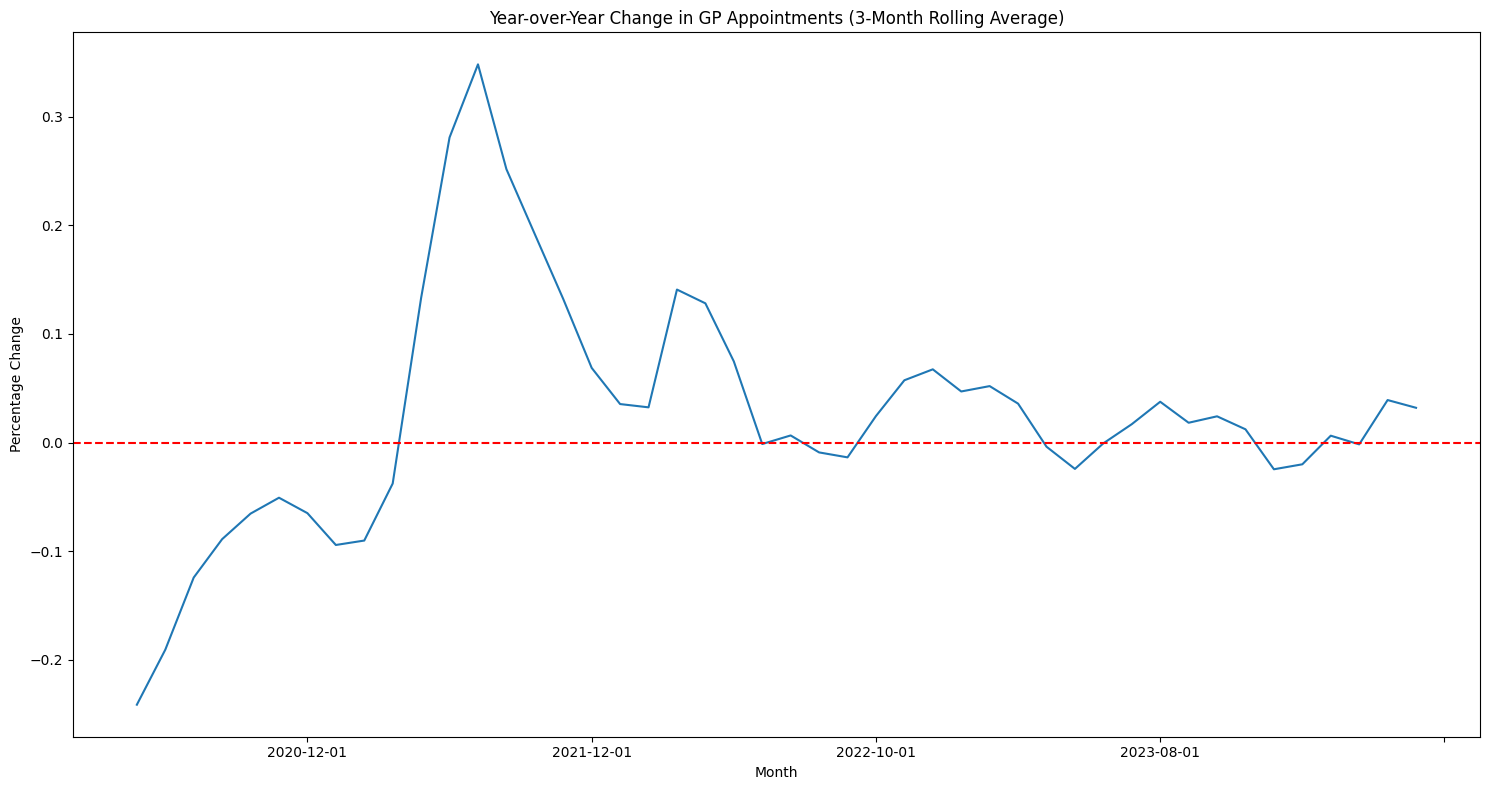

Significant decline (>10% year-over-year) first observed in: 2020-06-01


In [22]:
# Calculate 3-month rolling average of appointments
rolling_avg = gp_appointments.groupby('appointment_month')['count_of_appointments'].sum().rolling(window=3).mean()

# Calculate percentage change from the previous year
yoy_change = rolling_avg.pct_change(periods=12)

# Plot the year-over-year change
plt.figure(figsize=(15, 8))
yoy_change.plot()
plt.title('Year-over-Year Change in GP Appointments (3-Month Rolling Average)')
plt.xlabel('Month')
plt.ylabel('Percentage Change')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Identify the point where the decline became significant
significant_decline = yoy_change[yoy_change < -0.1].first_valid_index()
print(f"Significant decline (>10% year-over-year) first observed in: {significant_decline}")

In [23]:
def extend_fte_data(FTE_ar_merge, start_date, end_date):
    # Sort the DataFrame by icb_name and appointment_month
    FTE_ar_merge_sorted = FTE_ar_merge.sort_values(['icb_name', 'appointment_month'])
    
    # Find the earliest data
    earliest_date = FTE_ar_merge_sorted['appointment_month'].min()
    print(f"Earliest date in original data: {earliest_date}")
    earliest_data = FTE_ar_merge_sorted[FTE_ar_merge_sorted['appointment_month'] == earliest_date]
    
    # Create a DataFrame with all months in the specified range
    all_months = pd.DataFrame({'appointment_month': pd.date_range(start=start_date, end=end_date, freq='MS')})
    print(f"Date range in all_months: {all_months['appointment_month'].min()} to {all_months['appointment_month'].max()}")
    
    # Create a list to store the extended data
    extended_data_list = []
    
    # Iterate through the ICBs
    for icb in FTE_ar_merge_sorted['icb_name'].unique():
        icb_data = FTE_ar_merge_sorted[FTE_ar_merge_sorted['icb_name'] == icb].copy()
        icb_earliest = earliest_data[earliest_data['icb_name'] == icb].copy()
        
        # Create DataFrame for the period before the earliest date
        pre_earliest = all_months[all_months['appointment_month'] < earliest_date].copy()
        pre_earliest['icb_name'] = icb
        for col in icb_earliest.columns:
            if col not in ['appointment_month', 'icb_name']:
                pre_earliest[col] = icb_earliest[col].iloc[0]
        
        # Combine pre-earliest data with actual data
        extended_icb_data = pd.concat([pre_earliest, icb_data], ignore_index=True)
        
        # Ensure all months are present and forward fill any missing data
        extended_icb_data = extended_icb_data.set_index('appointment_month')
        extended_icb_data = extended_icb_data.reindex(all_months['appointment_month'])
        extended_icb_data = extended_icb_data.ffill()
        extended_icb_data['icb_name'] = icb
        
        extended_data_list.append(extended_icb_data.reset_index())
    
    # Combine all extended data
    extended_data = pd.concat(extended_data_list, ignore_index=True)
    
    # Recalculate Working Days, Max Appointments, and Utilisation Rate
    extended_data['Working Days'] = extended_data['appointment_month'].apply(lambda x: get_working_days_in_month(x.year, x.month))
    extended_data['Max Appointments'] = extended_data['fte-gp'] * extended_data['Working Days'] * 25
    extended_data['Utilisation Rate'] = extended_data['count_of_appointments'] / extended_data['Max Appointments']
    
    print(f"Date range in extended_data: {extended_data['appointment_month'].min()} to {extended_data['appointment_month'].max()}")
    
    return extended_data

start_date = '2021-09-01'
end_date = '2024-06-30'
extended_FTE_ar_merge = extend_fte_data(FTE_ar_merge, start_date, end_date)

# Check the result
print(extended_FTE_ar_merge['appointment_month'].min())
print(extended_FTE_ar_merge['appointment_month'].max())
print(extended_FTE_ar_merge['appointment_month'].nunique())

Earliest date in original data: 2022-09-01 00:00:00
Date range in all_months: 2021-09-01 00:00:00 to 2024-06-01 00:00:00
Date range in extended_data: 2021-09-01 00:00:00 to 2024-06-01 00:00:00
2021-09-01 00:00:00
2024-06-01 00:00:00
34


In [24]:
# Sort the dataframe by date and forward fill FTE data
FTE_ar_merge_sorted = FTE_ar_merge.sort_values(['icb_name', 'appointment_month'])
FTE_ar_merge_sorted['fte-gp'] = FTE_ar_merge_sorted.groupby('icb_name')['fte-gp'].ffill()

# Recalculate Max Appointments and Utilisation Rate
FTE_ar_merge_sorted['Max Appointments'] = FTE_ar_merge_sorted['fte-gp'] * FTE_ar_merge_sorted['Working Days'] * 25
FTE_ar_merge_sorted['Utilisation Rate'] = FTE_ar_merge_sorted['count_of_appointments'] / FTE_ar_merge_sorted['Max Appointments']

# Calculate average utilization rate for each ICB
icb_avg_utilization = FTE_ar_merge_sorted.groupby('icb_name')['Utilisation Rate'].mean().sort_values(ascending=False)

# Get the top 5 and bottom 5 ICBs
top_5_icbs = icb_avg_utilization.head(5).index.tolist()
bottom_5_icbs = icb_avg_utilization.tail(5).index.tolist()
highlighted_icbs = top_5_icbs + bottom_5_icbs

# Create a dictionary to map ICBs to their regions
icb_to_region = FTE_ar_merge_sorted.groupby('icb_name')['region_name'].first().to_dict()

# Create a list of regions and ICBs ordered by region and then alphabetically by ICB
regions = sorted(FTE_ar_merge_sorted['region_name'].unique())
ordered_icbs = {region: sorted([icb for icb in FTE_ar_merge_sorted['icb_name'].unique() if icb_to_region[icb] == region])
                for region in regions}

# Calculate average utilization rate for each month nationally
national_avg_utilization = FTE_ar_merge_sorted.groupby('appointment_month')['Utilisation Rate'].mean()

# Identify quarterly FTE update months
fte_update_months = pd.to_datetime(FTE_ar_merge[FTE_ar_merge['fte-gp'].notnull()]['appointment_month'].unique())
quarterly_updates = fte_update_months[fte_update_months.is_quarter_start]


In [25]:
# Filter the dataset to include only face-to-face and telephone appointments
filtered_ar = ar[ar['appt_mode'].isin(['Face-to-Face', 'Telephone'])]

# Group by appointment month and mode, and calculate the sum of appointments
monthly_appointments = filtered_ar.groupby(['appointment_month', 'appt_mode'])['count_of_appointments'].sum().reset_index()

# Pivot the table to have appointment modes as columns
pivot_table = monthly_appointments.pivot(index='appointment_month', columns='appt_mode', values='count_of_appointments').fillna(0)

# Calculate the total appointments per month
pivot_table['total'] = pivot_table.sum(axis=1)

# Calculate the percentage for face-to-face and telephone appointments
pivot_table['face-to-face_percentage'] = (pivot_table['Face-to-Face'] / pivot_table['total']) * 100
pivot_table['telephone_percentage'] = (pivot_table['Telephone'] / pivot_table['total']) * 100

# Create the plotly figure for the percentage of appointment modes
fig = go.Figure()

# Add the face-to-face percentage trace
fig.add_trace(go.Scatter(
    x=pivot_table.index,
    y=pivot_table['face-to-face_percentage'],
    mode='lines+markers',
    name='Face-to-Face',
    line=dict(color='blue')
))

# Add the telephone percentage trace
fig.add_trace(go.Scatter(
    x=pivot_table.index,
    y=pivot_table['telephone_percentage'],
    mode='lines+markers',
    name='Telephone',
    line=dict(color='red')
))

# Update layout of the figure
fig.update_layout(
    title='Percentage of Appointment Modes Per Month',
    xaxis_title='Month',
    yaxis_title='Percentage',
    yaxis=dict(showline=True, mirror=True),
    legend=dict(title='Appointment Mode'),
    margin=dict(l=40, r=40, t=40, b=40)
)

# Show the figure
fig.show()

In [26]:
# Use the extended data for your calculations and plot
FTE_ar_merge_sorted = extended_FTE_ar_merge.sort_values(['icb_name', 'appointment_month'])

# Recalculate Max Appointments and Utilisation Rate
FTE_ar_merge_sorted['Max Appointments'] = FTE_ar_merge_sorted['fte-gp'] * FTE_ar_merge_sorted['Working Days'] * 25
FTE_ar_merge_sorted['Utilisation Rate'] = FTE_ar_merge_sorted['count_of_appointments'] / FTE_ar_merge_sorted['Max Appointments']

# Calculate average utilization rate for each ICB
icb_avg_utilization = FTE_ar_merge_sorted.groupby('icb_name')['Utilisation Rate'].mean().sort_values(ascending=False)

# Get the top 5 and bottom 5 ICBs
top_5_icbs = icb_avg_utilization.head(5).index.tolist()
bottom_5_icbs = icb_avg_utilization.tail(5).index.tolist()
highlighted_icbs = top_5_icbs + bottom_5_icbs

# Create a dictionary to map ICBs to their regions
icb_to_region = FTE_ar_merge_sorted.groupby('icb_name')['region_name'].first().to_dict()

# Create a list of regions and ICBs ordered by region and then alphabetically by ICB
regions = sorted(FTE_ar_merge_sorted['region_name'].unique())
ordered_icbs = {region: sorted([icb for icb in FTE_ar_merge_sorted['icb_name'].unique() if icb_to_region[icb] == region])
                for region in regions}

# Calculate average utilization rate for each month nationally
national_avg_utilization = FTE_ar_merge_sorted.groupby('appointment_month')['Utilisation Rate'].mean()

# Identify quarterly FTE update months
fte_update_months = pd.to_datetime(FTE_ar_merge_sorted[FTE_ar_merge_sorted['fte-gp'].notnull()]['appointment_month'].unique())
quarterly_updates = fte_update_months[fte_update_months.is_quarter_start]

# Function to calculate trend line
def calculate_trendline(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    if np.sum(mask) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
        return slope * x + intercept
    else:
        return np.full_like(x, np.nan)
# Create the plot
fig2_GP2 = go.Figure()

# Add traces for each ICB, grouped by region
for region in regions:
    for icb in ordered_icbs[region]:
        icb_data = FTE_ar_merge_sorted[FTE_ar_merge_sorted['icb_name'] == icb]
        fig2_GP2.add_trace(go.Scatter(
            x=icb_data['appointment_month'],
            y=icb_data['Utilisation Rate'],
            mode='lines',
            name=icb,
            legendgroup=region,
            legendgrouptitle_text=region,
            hovertemplate=(
                '<b>%{fullData.name}</b><br>' +
                '%{x|%B %Y}<br>' +
                'Utilisation Rate: %{y:.2f}<extra></extra>'
            ),
            visible='legendonly' if icb not in highlighted_icbs else True,
            line=dict(width=1 if icb in highlighted_icbs else 1),
            opacity=1 if icb in highlighted_icbs else 0.5
        ))

# Add trace for national average utilization rate
fig2_GP2.add_trace(go.Scatter(
    x=national_avg_utilization.index,
    y=national_avg_utilization,
    mode='lines',
    name='National Average',
    line=dict(color='black', width=2, dash='dash'),
    hovertemplate=(
        '<b>National Average</b><br>' +
        '%{x|%B %Y}<br>' +
        'Utilisation Rate: %{y:.2f}<extra></extra>'
    )
))
# Add traces for each ICB, grouped by region
for region in regions:
    for icb in ordered_icbs[region]:
        icb_data = FTE_ar_merge_sorted[FTE_ar_merge_sorted['icb_name'] == icb]
        fig2_GP2.add_trace(go.Scatter(
            x=icb_data['appointment_month'],
            y=icb_data['Utilisation Rate'],
            mode='lines',
            name=icb,
            legendgroup=region,
            legendgrouptitle_text=region,
            hovertemplate=(
                '<b>%{fullData.name}</b><br>' +
                '%{x|%B %Y}<br>' +
                'Utilisation Rate: %{y:.2f}<extra></extra>'
            ),
            visible='legendonly' if icb not in highlighted_icbs else True,
            line=dict(width=2 if icb in highlighted_icbs else 1),
            opacity=1 if icb in highlighted_icbs else 0.5
        ))
        
# Add national average trend line
x_numeric = (national_avg_utilization.index - national_avg_utilization.index.min()).days
y = national_avg_utilization.values
national_trendline = calculate_trendline(x_numeric, y)
fig2_GP2.add_trace(go.Scatter(
    x=national_avg_utilization.index,
    y=national_trendline,
    mode='lines',
    name='National Average Trend',
    line=dict(color='rgba(0,0,0,0.5)', width=2, dash='dot'),
    showlegend=True
))

# Add markers for quarterly FTE updates
for update_month in quarterly_updates:
    fig2_GP2.add_vline(x=update_month, line_dash="dash", line_color="gray", opacity=0.3)

# Update layout
fig2_GP2.update_layout(
    title='GP Utilisation Rates by ICB Over Time (Top 5 Highest and Lowest Highlighted)',
    xaxis_title='Date',
    yaxis_title='Utilisation Rate',
    yaxis=dict(
        tickformat='.0%',  # Format y-axis ticks as percentages
        range=[0.6, 1.2],  # Adjust the range as needed (60% to 120%)
        title='Utilisation Rate',
        side='left',
        showgrid=True,
    ),
    hovermode='closest',
    legend_title='Regions and ICBs',
    legend=dict(
        groupclick="togglegroup",
        tracegroupgap=10,
        traceorder='grouped'
    ),
    height=900,
)

# Add a horizontal line at y=1 to represent 100% utilization
fig2_GP2.add_shape(
    type="line",
    x0=start_date,
    y0=1,
    x1=end_date,
    y1=1,
    line=dict(color="Red", width=1, dash="dash"),
)

# Update x-axis range explicitly
fig2_GP2.update_xaxes(range=[start_date, end_date])

# Get HTML string for fig1
fig2_GP2_html = fig2_GP2.to_html(full_html=False, include_plotlyjs='cdn')
fig2_GP2.show()

In [27]:
# Pivot table for appointments_regional, based on HCP Type, Appointment Status, and Appointment M
pivot_table_ar = pd.pivot_table(
   ar,
    values='count_of_appointments',  # The data to aggregate
    index=['appt_status', 'appt_mode'],  # Rows of the pivot table
    columns='hcp_type',  # Columns of the pivot table
    aggfunc='sum'  # Aggregation function
)
# Print the pivot table
print(pivot_table_ar)

hcp_type                         GP  Other Practice staff   Unknown
appt_status appt_mode                                              
Attended    Face-to-Face  411530270             512612327   6583972
            Home Visit      4206225               4673241   1068627
            Telephone     294671146             129646959   6389081
            Unknown         9976455              11767182  24404459
            Video/Online    8665146               6671226    199302
DNA         Face-to-Face   16744837              40987828    114839
            Home Visit       121447                181283    115617
            Telephone       5262677               4497005    187032
            Unknown          396267                823949    681677
            Video/Online     144380                202851       281
Unknown     Face-to-Face   16167000              34079257   1323548
            Home Visit      1038892               1108420    479298
            Telephone       8826458             

In [28]:
# Aggregate the data by month and appointment status
status_monthly_agg = ar.groupby(['appointment_month', 'appt_status'])['count_of_appointments'].sum().reset_index()

# Pivot the data to get separate columns for each appointment status
status_pivot_table = status_monthly_agg.pivot_table(
    values='count_of_appointments',
    index='appointment_month',
    columns='appt_status',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Calculate the total number of appointments per month, excluding the 'appointment_month' column
status_pivot_table['Total'] = status_pivot_table.loc[:, status_pivot_table.columns != 'appointment_month'].sum(axis=1)

# Calculate the proportion of attended and DNA appointments
status_pivot_table['Attended'] = status_pivot_table['Total'] - status_pivot_table.get('DNA', 0)
status_pivot_table['DNA_Proportion'] = status_pivot_table['DNA'] / status_pivot_table['Total']
status_pivot_table['Attended_Proportion'] = status_pivot_table['Attended'] / status_pivot_table['Total']

# Print the DataFrame
print(status_pivot_table.head())


appt_status appointment_month  Attended      DNA  Unknown     Total  \
0                  2019-04-01  22649066  1203082  1251593  23852148   
1                  2019-05-01  23427143  1216004  1293805  24643147   
2                  2019-06-01  22002902  1147937  1274417  23150839   
3                  2019-07-01  24917765  1343953  1257987  26261718   
4                  2019-08-01  21687104  1132269  1144497  22819373   

appt_status  DNA_Proportion  Attended_Proportion  
0                  0.050439             0.949561  
1                  0.049345             0.950655  
2                  0.049585             0.950415  
3                  0.051175             0.948825  
4                  0.049619             0.950381  


In [29]:
# Group by appointment month and appointment status, then sum the count of appointments
appointments_grouped = ar.groupby(['appointment_month', 'appt_status'])['count_of_appointments'].sum().unstack(fill_value=0).reset_index()

# Calculate total appointments correctly by summing only the columns with statuses
appointment_status_columns = [col for col in appointments_grouped.columns if col not in ['appointment_month']]
appointments_grouped['Total'] = appointments_grouped[appointment_status_columns].sum(axis=1)

# Calculate DNA rate
appointments_grouped['DNA_Rate'] = (appointments_grouped['DNA'] / appointments_grouped['Total']) * 100

# Display the result
print(appointments_grouped[['appointment_month', 'DNA_Rate']])

# Get the most recent DNA rate
most_recent_dna_rate = appointments_grouped.iloc[-1]['DNA_Rate'] / 100

print(f"The most recent DNA rate is: {most_recent_dna_rate:.2%}")                

appt_status appointment_month  DNA_Rate
0                  2019-04-01  5.043915
1                  2019-05-01  4.934451
2                  2019-06-01  4.958511
3                  2019-07-01  5.117536
4                  2019-08-01  4.961876
5                  2019-09-01  5.046728
6                  2019-10-01  5.202476
7                  2019-11-01  5.268529
8                  2019-12-01  5.342923
9                  2020-01-01  4.768143
10                 2020-02-01  5.036169
11                 2020-03-01  4.842858
12                 2020-04-01  2.987364
13                 2020-05-01  2.732723
14                 2020-06-01  2.866593
15                 2020-07-01  3.096978
16                 2020-08-01  3.315929
17                 2020-09-01  4.282679
18                 2020-10-01  4.792576
19                 2020-11-01  4.068592
20                 2020-12-01  4.223615
21                 2021-01-01  3.989589
22                 2021-02-01  3.582579
23                 2021-03-01  3.532568


In [30]:
# Calculate average attended and DNA proportions
average_attended_proportion = status_pivot_table['Attended_Proportion'].mean()
average_dna_proportion = status_pivot_table['DNA_Proportion'].mean()

# Calculate average attended and DNA proportions
average_attended_proportion = status_pivot_table['Attended_Proportion'].mean()
average_dna_proportion = status_pivot_table['DNA_Proportion'].mean()

# Create the plot
fig3_DNA1 = go.Figure()

fig3_DNA1.add_trace(go.Scatter(
    x=status_pivot_table['appointment_month'],
    y=status_pivot_table['Attended_Proportion'],
    mode='lines+markers',
    name='Attended Proportion',
    marker=dict(symbol='circle'),
    line=dict(color='blue'),
    hovertemplate=('%{x|%B %Y}<br>Attended Proportion: %{y:.2%}<extra></extra>')
))
fig3_DNA1.add_trace(go.Scatter(
    x=status_pivot_table['appointment_month'],
    y=status_pivot_table['DNA_Proportion'],
    mode='lines+markers',
    name='DNA Proportion',
    marker=dict(symbol='circle'),
    line=dict(color='red'),
    hovertemplate=('%{x|%B %Y}<br>DNA Proportion: %{y:.2%}<extra></extra>')
))
fig3_DNA1.add_annotation(
    x=pd.to_datetime('2022-01-01'),
    y=0.9,
    text=f'Average Attended: {average_attended_proportion:.2%}',
    showarrow=False,
    font=dict(color='blue', size=12)
)
fig3_DNA1.add_annotation(
    x=pd.to_datetime('2022-01-01'),
    y=0.1,
    text=f'Average DNA: {average_dna_proportion:.2%}',
    showarrow=False,
    font=dict(color='red', size=12)
)
fig3_DNA1.update_layout(
    title='Proportion of Attended vs. DNA Appts',
    xaxis_title='Month',
    yaxis_title='Proportion',
    xaxis=dict(tickformat="%B %Y", tickangle=45),
    legend_title='Proportions',
    height=600,  # Set the height to 600
)

# Get HTML string for fig3_DNA1
fig3_DNA1_html = fig3_DNA1.to_html(full_html=False, include_plotlyjs='cdn')
fig3_DNA1.show()

In [31]:
# Verify and handle any potential non-numeric values in 'time_between_book_and_appt'
ar['time_between_book_and_appt'] = ar['time_between_book_and_appt'].astype(str)

# Group by 'time_between_book_and_appointment' and 'appointment_status' and sum the counts
dna_groupby = ar.groupby(['time_between_book_and_appt', 'appt_status'])['count_of_appointments'].sum().reset_index()

# Filter out 'Unknown' from the dataset
dna_groupby = dna_groupby[dna_groupby['time_between_book_and_appt'] != 'Unknown / Data Quality']

# Pivot the data to get separate columns for each appointment status
dna_pivot = dna_groupby.pivot_table(
    values='count_of_appointments',
    index='time_between_book_and_appt',
    columns='appt_status',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Calculate the total number of appointments, excluding the non-numeric columns
dna_pivot['Total'] = dna_pivot.loc[:, dna_pivot.columns != 'time_between_book_and_appt'].sum(axis=1)

# Calculate the DNA rate
dna_pivot['DNA_Rate'] = (dna_pivot['DNA'] / dna_pivot['Total']) * 100

# Define the desired order of categories
category_order = ['Same Day', '1 Day', '2 to 7 Days', '8 to 14 Days', '15 to 21 Days', '22 to 28 Days', 'More than 28 Days']

# Ensure 'time_between_book_and_appt' is ordered correctly
dna_pivot['time_between_book_and_appt_ordered'] = pd.Categorical(dna_pivot['time_between_book_and_appt'], categories=category_order, ordered=True)

# Sort the dataframe based on the new ordered categorical column
dna_pivot_sorted = dna_pivot.sort_values('time_between_book_and_appt_ordered').drop(columns='time_between_book_and_appt_ordered')

# Filter out 'Unknown / Data Issue' from the sorted dataframe
dna_pivot_sorted = dna_pivot_sorted[dna_pivot_sorted['time_between_book_and_appt'] != 'Unknown / Data Issue']

# Display the pivot table to verify sorting
print(dna_pivot_sorted)

# Create subplots with shared x-axis
fig3_DNA2 = make_subplots(specs=[[{"secondary_y": True}]])

# Bar plot for total appointments
fig3_DNA2.add_trace(
    go.Bar(
        x=dna_pivot_sorted['time_between_book_and_appt'],
        y=dna_pivot_sorted['Total'],
        name='Total Appointments',
        marker=dict(color='blue', opacity=0.6)
    ),
    secondary_y=False
)

# Line plot for DNA rate
fig3_DNA2.add_trace(
    go.Scatter(
        x=dna_pivot_sorted['time_between_book_and_appt'],
        y=dna_pivot_sorted['DNA_Rate'],
        name='DNA Rate',
        mode='lines+markers',
        marker=dict(color='red', symbol='circle')
    ),
    secondary_y=True
)

# Set x-axis title and category order
fig3_DNA2.update_xaxes(
    title_text="Time Between Booking and Appointment", 
    tickmode='array', 
    tickvals=list(range(len(category_order))), 
    ticktext=category_order
)

# Set y-axes titles
fig3_DNA2.update_yaxes(
    title_text="Total Appointments", 
    secondary_y=False, 
    color='blue', 
    range=[0, 450000000], 
    tickvals=[50000000 * i for i in range(10)]
)
fig3_DNA2.update_yaxes(
    title_text="DNA Rate (%)", 
    secondary_y=True, 
    color='red', 
    range=[1, 10], 
    tickvals=[i for i in range(1, 11)]
)

# Set the layout and title
fig3_DNA2.update_layout(
    title_text='Total Appts & DNA Rate vs. Time Booking to Appt',
    height=600,
    template='plotly_white'
)
# Get HTML string for fig1_trend1
fig3_DNA2_html = fig3_DNA2.to_html(full_html=False, include_plotlyjs='cdn')

# Show the plot
fig3_DNA2.show()


appt_status time_between_book_and_appt   Attended       DNA   Unknown  \
6                             Same Day  670925847  12945114  18869670   
0                                1 Day  120377349   5402039   5103438   
2                          2 to 7 Days  276766305  18380070  14138639   
5                    More than 28 Days   48852755   5575622  10781253   
1                       15  to 21 Days   89435148   8281829   8590296   
3                       22  to 28 Days   55959339   5321465   6702690   
4                        8  to 14 Days  169964536  14525094  12485810   

appt_status      Total  DNA_Rate  
6            702740631  1.842090  
0            130882826  4.127386  
2            309285014  5.942761  
5             65209630  8.550305  
1            106307273  7.790463  
3             67983494  7.827584  
4            196975440  7.374063  


In [32]:
# Ensure appointment_month is datetime format
ar['appointment_month'] = pd.to_datetime(ar['appointment_month'])

# Group by 'appointment_month' and 'time_between_book_and_appt', summing 'count_of_appointments'
booking_agg = ar.groupby(['appointment_month', 'time_between_book_and_appt'])['count_of_appointments'].sum().reset_index()

booking_agg = booking_agg[~booking_agg['time_between_book_and_appt'].isin(['Unknown / Data Issue', 'Unknown / Data Quality'])]

# Pivot the data to have 'time_between_book_and_appointment' as columns
wait_time_pivot = booking_agg.pivot_table(
    values='count_of_appointments',
    index='appointment_month',
    columns='time_between_book_and_appt',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Melt the pivot table to long format for plotting
melted_data = wait_time_pivot.melt(id_vars='appointment_month', var_name='Time Between Booking and Appointment', value_name='Count of Appointments')

# Create line plot with Plotly
fig4_wait1 = px.line(
    melted_data,
    x='appointment_month',
    y='Count of Appointments',
    color='Time Between Booking and Appointment',
    title='Time Between Booking and Appointments'
)

# Add trend lines for each category
for name, color in zip(melted_data['Time Between Booking and Appointment'].unique(), px.colors.qualitative.Plotly):
    subset = melted_data[melted_data['Time Between Booking and Appointment'] == name]
    add_trend_line(fig4_wait1, subset, 'appointment_month', 'Count of Appointments', name, color)

# Update layout to match the required specifications
fig4_wait1.update_layout(
    xaxis_title='Month',
    yaxis_title='Count of Appointments',
    xaxis=dict(
        tickmode='linear',
        dtick='M6',
        tickformat='%b %y',
        tickangle=45
    ),
    yaxis=dict(
        gridcolor='rgba(200, 200, 200, 0.2)',
        gridwidth=0.01,
        griddash='solid',
        showgrid=True,
        zeroline=False
    ),
    legend=dict(
        title='',
        orientation='v',
        yanchor='middle',
        y=0.5,
        xanchor='right',
        x=1.1
    ),
    template='plotly_white'
)

# Get HTML string for fig4_wait1
fig4_wait1_html = fig4_wait1.to_html(full_html=False, include_plotlyjs='cdn')

# Show the plot
fig4_wait1.show()

In [33]:
# Assign numerical weights to each category
weights = {
    'Same Day': 0,
    '1 Day': 1,
    '2 to 7 Days': 4.5,
    '8 to 14 Days': 11,
    '15 to 21 Days': 18,
    '22 to 28 Days': 25,
    'More than 28 Days': 35,
    'Unknown / Data Quality': None  # Exclude this from calculations
}

# Add weights to DataFrame and filter out rows with None weights
ar['weight'] = ar['time_between_book_and_appt'].map(weights)
ar_filtered = ar.dropna(subset=['weight'])

# Ensure 'appointment_month' is in datetime format
ar_filtered['appointment_month'] = pd.to_datetime(ar_filtered['appointment_month'], format='%Y-%m', errors='coerce')

# Calculate weighted average wait time over time for each location
weighted_avg_over_time = ar_filtered.groupby(['appointment_month', 'icb_name']).apply(
    lambda x: (x['count_of_appointments'] * x['weight']).sum() / x['count_of_appointments'].sum()
).reset_index(name='weighted_avg_wait_time')

# Calculate overall average wait time for each ICB location
overall_avg_wait_time = weighted_avg_over_time.groupby('icb_name')['weighted_avg_wait_time'].mean().reset_index()

# Identify the top 5 and bottom 5 locations based on overall average wait time
top_5_locations = overall_avg_wait_time.nlargest(5, 'weighted_avg_wait_time')[['icb_name']]
bottom_5_locations = overall_avg_wait_time.nsmallest(5, 'weighted_avg_wait_time')[['icb_name']]

# Combine the top 5 and bottom 5 locations and sort by average wait time
combined_locations = pd.concat([top_5_locations, bottom_5_locations])
combined_locations = combined_locations.merge(overall_avg_wait_time, on='icb_name').sort_values('weighted_avg_wait_time', ascending=False)

# Filter the DataFrame to include only the top 5 and bottom 5 locations
filtered_data = weighted_avg_over_time[weighted_avg_over_time['icb_name'].isin(combined_locations['icb_name'])].copy()

# Ensure the data is in the correct format for plotting
filtered_data['appointment_month'] = pd.to_datetime(filtered_data['appointment_month'])

# Handle any potential NaN values before plotting
filtered_data.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
filtered_data.dropna(subset=['weighted_avg_wait_time'], inplace=True)

# Create the figure
fig4_wait2 = go.Figure()

# Plot the results based on the sorted order
for icb_name in combined_locations['icb_name']:
    icb_data = filtered_data[filtered_data['icb_name'] == icb_name]
    fig4_wait2.add_trace(go.Scatter(
        x=icb_data['appointment_month'],
        y=icb_data['weighted_avg_wait_time'],
        mode='lines',
        name=icb_name,
        hovertemplate='<b>%{fullData.name}</b><br>%{x|%B %Y}<br>Weighted Avg Wait Time: %{y:.2f} days<extra></extra>'
    ))

# Filter data for trend lines
top_5_data = filtered_data[filtered_data['icb_name'].isin(top_5_locations['icb_name'])]
bottom_5_data = filtered_data[filtered_data['icb_name'].isin(bottom_5_locations['icb_name'])]

# Adding trend lines for top 5 locations
add_trend_line(fig4_wait2, top_5_data, 'appointment_month', 'weighted_avg_wait_time', 'Top 5', 'blue')

# Adding trend lines for bottom 5 locations
add_trend_line(fig4_wait2, bottom_5_data, 'appointment_month', 'weighted_avg_wait_time', 'Bottom 5', 'red')

# Update layout
fig4_wait2.update_layout(
    title='Weighted Average Wait Time Over Time by Location (Top 5 and Bottom 5)',
    xaxis_title='Appointment Month',
    yaxis_title='Weighted Average Wait Time (days)',
    xaxis=dict(tickangle=45),
    legend_title='Location',
    height=1000,
    template='plotly_white',
    margin=dict(t=40, b=80)
)
# Adjust the plot area to be wider
fig4_wait2.update_xaxes(domain=[0, 1])  # Make the plot area use 85% of the width

# Get HTML string for fig1_trend1
fig4_wait2_html = fig4_wait2.to_html(full_html=False, include_plotlyjs='cdn')

# Show the figure
fig4_wait2.show()

C:\Users\willi\AppData\Local\Temp\ipykernel_18456\1270061321.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\willi\AppData\Local\Temp\ipykernel_18456\1270061321.py:21: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [34]:
# Filter data for the most recent month
most_recent_month = ar['appointment_month'].max()
recent_data = ar[ar['appointment_month'] == most_recent_month]

# Apply weights to the data
recent_data['weights'] = recent_data['time_between_book_and_appt'].map(weights)

# Filter out rows with None weights (Unknown / Data Quality)
filtered_recent_data = recent_data.dropna(subset=['weights'])

# Calculate the weighted average time
total_weighted_time = (filtered_recent_data['weights'] * filtered_recent_data['count_of_appointments']).sum()
total_appointments = filtered_recent_data['count_of_appointments'].sum()

average_time_between_booking_and_appointment = total_weighted_time / total_appointments

print(f"Average Time Between Booking and Appointment for {most_recent_month.strftime('%B %Y')}: {average_time_between_booking_and_appointment:.2f} days")

Average Time Between Booking and Appointment for May 2024: 3.43 days


C:\Users\willi\AppData\Local\Temp\ipykernel_18456\3572445935.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Healthcare Data Dashboard</title>
    <style>        
        .narrative-box {{
            background-color: #f0f0f0;
            border-left: 5px solid #005eb8;
            padding: 25px;
            margin-top: 20px;
            margin-bottom: 20px;
            font-size: 16px;
            line-height: 1.6;
        }}
           .narrative-box h4 {{
            margin-top: 0;
            color: #005eb8;
        }}
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Healthcare Data Dashboard</title>
    <style>
        * {{
            font-family: Arial, Helvetica, sans-serif !important;
        }}
        
        body, h1, h2, h3, h4, h5, h6, p, div, span {{
            font-family: Arial, Helvetica, sans-serif;
        }}
        h1 {{
            font-size: 38px;  
        }}
        h2 {{
            font-size: 30px;  
        }}
        h3 {{
            font-size: 24px; 
        }}
        .stat-container {{
            display: flex;
            justify-content: space-around;
            background-image: url('c:/Users/willi/OneDrive/Documents/NHS Digital Project/banner.png');
            background-size: cover;
            color: white;
            padding: 20px;
            margin: 0;
        }}
        .stat {{
            text-align: center;
            font-size: 24px;
        }}
        .section {{
            margin: 20px;
        }}
        .plot-container {{
            margin: 20px;
            width: 100%;
        }}
        .plots-row {{
            display: flex;
            justify-content: space-between;
        }}
        .plot-container iframe {{
            width: 100%;
            height: 1000px;
            border: none;
        }}
        .section-header {{
            background-image: url('c:/Users/willi/OneDrive/Documents/NHS Digital Project/header.png');
            background-size: cover;
            color: black;
            text-align: center;
            padding: 10px;
            margin-bottom: 0;  /* Adjust margin to remove gap */
            position: relative;
        }}
        .section-header h2 {{
            background-color: rgba(0, 0, 0, 0);
            display: inline-block;
            padding: 10px;
        }}
    .plots-row {{
        display: flex;
        justify-content: space-between;
        flex-wrap: wrap;
    }}
    .plot-container {{
        width: 100%;  /* Default to full width */
        margin-bottom: 20px;
    }}
    .plot-container-half {{
        width: 48%;  /* Use this class for side-by-side plots */
    }}
    @media (max-width: 768px) {{
        .plot-container-half {{
            width: 100%;  /* Full width on smaller screens */
        }}
    }}
    .header-container {{
        display: flex;
        align-items: center;
        justify-content: center;
        position: relative;
        padding: 10px 0;
        margin-bottom: 20px;    
    }}
    .logo-container {{
        position: absolute;
        left: 25px; /* Adjust this value to align with the banners below */
        top: 50%;
        transform: translateY(-50%);
    }}

    .logo {{
        width: 100px; /* Adjust based on your logo size */
        height: auto;
    }}
    .dashboard-title {{
        margin: 0;
        text-align: center;
        flex-grow: 1;
    }}
    .section, .stat-container {{
    padding-left: 25px; /* Should match the left value of .logo-container */
    padding-right: 20px;
    }}
</style>
</head>
<body>
    <div class="header-container">
        <div class="logo-container">
    <img src="c:/Users/willi/OneDrive/Documents/NHS Digital Project/nhs logo.png" alt="NHS Logo" class="logo">
        </div>
        <h1 class="dashboard-title">NHS Digital - Dashboard</h1>
    </div>
        <div class="narrative-box">
        <h4>Dashboard notes</h4>
        <p>This dashboard was created by web scraping patient appointment statistics and general practise workforce data from the NHS Digital website. </p>
        </div>
    </div>
    <!-- Section 1: Appointment Trends -->
    <div class="section">
        <div class="section-header">
            <h2>Appointment Trends</h2>
        </div>
        <div class="stat-container">
            <div class="stat" style="text-align:left;">
                <div>Average number of appointments per month per ICB: {avg_appointments_per_month_icb:,.2f}</div>
            </div>
            <!-- Add other high-level KPI points here -->
        </div>
        <div class="plot-container">
            <h3>Total Appointments in the NHS England Network along with trend line</h3>
            {fig1_trend1_html}
        <div class="plot-container">
            <h3>SARIMA Model with national categories dataset, filtered for general practise and care related events</h3>
            {fig1_trend3_html}
            <div>Monthly Average Appointments for the preceding 12 months: {preceding_avg_patients_month:,.2f}</div>
            <div>Yearly Appointments for the preceding 12 months: {preceding_total_patients_year:,.2f}</div>
            <div>Monthly Average Appointments for the forecasted 12 months: {forecasted_avg_patients_month:,.2f}</div>
            <div>Yearly Appointments for the forecasted 12 months: {forecasted_total_patients_year:,.2f}</div>
        </div>
        <div class="narrative-box">
            <h4>Appointment Trends Analysis</h4>
            <p>There is an increasing trend for more patients in the NHS network. Using our SARIMA Model with national categories dataset, filtered for general practise and care related events, the average GP practise could see a 7% increase to number of appointments per month.</p>
        </div>
    </div>
    
    <!-- Section 2: GP FTE (Full Time Equivalence) -->
    <div class="section">
        <div class="section-header">
            <h2>GP FTE (Full Time Equivalence)</h2>
        </div>
        <div class="stat-container">
            <div class="stat">
                <div>FTE for GPs for the most recent month ({most_recent_month.strftime('%B %Y')})</div>
                <div>{sum_total_fte} Full Time Equivalent GPs in England</div>
            </div>
            <!-- Add other high-level KPI points here -->
        </div>
        <div class="plot-container">
            <h3>GP FTE - showing less than full time, full time, and overtime GPs</h3>
            {fig2_GP1_html}
        </div>
        <div class="narrative-box">
            <h4>GP Work Patterns</h4>
            <p>The number of GPs choosing to work less than full-time has been climbing. This is likely because doctors are, understandably, moving towards working patterns that allow them to better control their hours and workload in order to reduce stress, ill-health and burnout and to improve work-life balance.</p>
            <p>Although these GPs may be working less than one FTE on paper, in reality 'part time' as a GP very often means working a number of additional unpaid hours just to get through the large numbers of appointments and essential patient follow-up (administrative) work.</p>
            <p><strong>Fewer doctors are looking after greater numbers of patients.</strong></p>
        </div>
        <div class="plot-container">
            <h3>Utilisation Rate for GPs by ICB</h3>
            {fig2_GP2_html}
        </div>
        <div class="narrative-box">
            <h4>GP Utilisation Analysis</h4>
            <p>The GP Utilisation calculation was made by estimating the maximum number of patients a GP should see per month as recommended by the European Union of General Practitioners and British Medical Association (25 patients/day).</p>
            <p>FTE x Working Days/Month x 25 patients per day = Max Appointments</p>
            <p>We then divided this by the number of GP appointments in the networks to get a true utilisation of GP surgeries, where 25 patients/day would be 100% utilisation rate. (noted as the red line)</p>
            <p>We see an increasing trend of GP utilisation across the network. It's important to note that there is a high risk of decision fatigue, clinical errors and patient harm, and clinician burn out at these levels.</p>
        </div>
    </div>
        <div class="plot-container">
            <img src="c:/Users/willi/OneDrive/Documents/NHS Digital Project/FTE Calc.png" alt="Utilisation Rate for GPs by ICB" style="width:35%;height:auto;">
        </div>
    </div>
        </div>
    </div>
    <!-- Section 3: Did Not Attend Analysis -->
    <div class="section">
        <div class="section-header">
            <h2>Did Not Attend Analysis</h2>
        </div>
        <div class="stat-container">
            <div class="stat">
                <div>Current Did Not Attend Rate: {most_recent_dna_rate:.2%}</div>
            </div>
            <!-- Add other high-level KPI points here -->
        </div>
        <div class="plots-row">
            <div class="plot-container plot-container-half">
                {fig3_DNA1_html}
            </div>
            <div class="plot-container plot-container-half">
                {fig3_DNA2_html}
            </div>
        </div>
        <div class="narrative-box">
            <h4>Did Not Attend (DNA) Analysis</h4>
            <p>The number of did not attend has remained consistent at ~4%. However, when we compare the did not attend proportion to the time between booking and the appointment, we see that the proportion increases as the time between booking increases (plateauing at 8-14 days).</p>
        </div>
    </div>
    
    <!-- Section 4: Wait Time Analysis -->
    <div class="section">
        <div class="section-header">
            <h2>Wait Time Analysis</h2>
        </div>
        <div class="stat-container">
            <div class="stat">
                <div>Average Time Between Booking and Appointment for {most_recent_month.strftime('%B %Y')}: {average_time_between_booking_and_appointment:.2f} days</div>
            </div>
            <!-- Add other high-level KPI points here -->
        </div>
        <div class="plot-container">
            {fig4_wait1_html}
        </div>
        <div class="plot-container">
            {fig4_wait2_html}
        </div>
        <div class="narrative-box">
            <h4>Wait Time Analysis</h4>
            <p>There is an inequality of wait times across the country. Wait times do not appear to be increasing in the urban areas (noted here with London and Coventry ICBs), however, wait times in rural ICBs are dramatically increasing. This is likely due to the fact that a patient has a choice of several ICBs to choose from in London, which increases overall efficiency.</p>
        </div>
    </div>
</body>
</html>
    </div>
</body>
</html>
"""


# Save the combined HTML content to a file
with open("dashboard.html", "w") as file:
    file.write(html_content)